## Specific Task 1 (if you are interested in “Graph Representation Learning for Fast Detector Simulation” project):

* Please train a simple graph autoencoder on this dataset. Please show a visual side-by side comparison of the original and reconstructed events and appropriate evaluation metric of your choice. Compare to the VAE model results.


In [1]:
import torch
import numpy as np 
import h5py
import os
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
from tqdm.autonotebook import tqdm
import torchvision
import random
import cv2
import torch_geometric
from torch_geometric.nn import GCNConv,Sequential
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from sklearn.neighbors import kneighbors_graph
import matplotlib.colors as colors


/tmp/ipykernel_120784/338377710.py:8: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
seed = 0
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


## DATA PREPROCESSING

#### Here we take each channel seperately and first extract non zero coordinates and the respective values modeling it the node features of shape (N,3) where 3 is the number of features containing (x,y,energy hit value at the coordinate)

In [3]:
data_path = 'quark-gluon_data-set_n139306.hdf5'
num_samples = 12000

x_jets = np.array(h5py.File(data_path,'r')['X_jets'][:num_samples])
labels  = np.array(h5py.File(data_path,'r')['y'][:num_samples])
x_jets.shape

(12000, 125, 125, 3)

In [4]:

def preprocess_image(image,channel_idx):

    # Get the non-zero hit locations
    channel = image[:,:,channel_idx]
    nonzero_indices= np.nonzero(channel)  
    x_coords, y_coords = nonzero_indices[1], nonzero_indices[0]

    # Get the hit energies at the non-zero locations
    hit_energies = channel[nonzero_indices]

    # Concatenate the x, y locations and hit energies
    processed_data = np.column_stack((x_coords, y_coords, hit_energies))

    return processed_data

In [5]:
processed_tracks= []
processed_ecals = []
processed_hcals = []
for img in x_jets:
    processed_track = preprocess_image(img,0)
    processed_ecal = preprocess_image(img,1)
    processed_hcal = preprocess_image(img,2)

    processed_tracks.append(processed_track)
    processed_ecals.append(processed_ecal)
    processed_hcals.append(processed_hcal)

In [6]:
def graph_representation(point_clouds,n_neighbor = 10):
    graph_representation = []
    for i,point_cloud in enumerate(point_clouds):
        edges = kneighbors_graph(point_cloud,n_neighbors=n_neighbor,mode='connectivity')

        edges = edges.tocoo()

        edge_index = torch.tensor(np.vstack((edges.row,edges.col))).type(torch.long)
        edge_attr = torch.tensor(edges.data.reshape(-1,1))
        label  = torch.tensor(int(labels[i]),dtype=torch.long)
        data = torch_geometric.data.Data(x = torch.tensor(point_cloud), edge_index = edge_index, edge_attr=edge_attr,y=label)
        graph_representation.append(data)

    return graph_representation


In [7]:
data_tracks = graph_representation(processed_tracks,3)
data_ecal = graph_representation(processed_ecals,3)
data_hcal = graph_representation(processed_hcals,3)

In [8]:
train_tracks = data_tracks[:10000]
test_tracks = data_tracks[10000:]

train_ecal = data_ecal[:10000]
test_ecal = data_ecal[10000:]

train_hcal = data_hcal[:10000]
test_hcal = data_hcal[10000:]

batch_size = 128

train_tracks_dataloader = DataLoader(train_tracks,batch_size=batch_size,shuffle=True)
test_tracks_dataloader = DataLoader(test_tracks,batch_size=batch_size,shuffle=False)

train_ecal_dataloader = DataLoader(train_ecal,batch_size=batch_size,shuffle=True)
test_ecal_dataloader = DataLoader(test_ecal,batch_size=batch_size,shuffle=False)

train_hcal_dataloader = DataLoader(train_hcal,batch_size=batch_size,shuffle=True)
test_hcal_dataloader = DataLoader(test_hcal,batch_size=batch_size,shuffle=False)

In [9]:
class GraphAutoEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()

        self.enc_conv1 = GCNConv(input_dim,hidden_dim)
        self.enc_conv2 = GCNConv(hidden_dim,hidden_dim*2)
        self.enc_conv3 = GCNConv(hidden_dim*2, output_dim)

        self.dec_conv1 = GCNConv(output_dim,hidden_dim*2)
        self.dec_conv2 = GCNConv(hidden_dim*2,hidden_dim)
        self.dec_conv3 = GCNConv(hidden_dim,input_dim)
 
    def forward(self, data):
        x, edge_index, edge_attr = data.x.float(), data.edge_index, data.edge_attr.float()

        x = self.enc_conv1(x,edge_index)
        x = x.relu()
        x = self.enc_conv2(x,edge_index)
        x = x.relu()
        z = self.enc_conv3(x,edge_index)

        x = self.dec_conv1(z,edge_index)
        x = x.relu()
        x = self.dec_conv2(x,edge_index)
        x = x.relu()
        x = self.dec_conv3(x,edge_index)
        return x

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphAutoEncoder(input_dim =3 , hidden_dim = 64, output_dim=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(50):
    model.train()
    for train_data in train_tracks_dataloader:
        train_data = train_data.to(device)
        # print(train_data)
        optimizer.zero_grad()
        output= model(train_data)
        # print(output.shape)
        # print(train_data.x.shape)
        loss = criterion(output,train_data.x.float())
        
        loss.backward()
        optimizer.step()
    if (epoch+1)%5 ==0:
        print(f'Epoch: {epoch+1}, Train Loss: {loss:.4f}')

Epoch: 5, Train Loss: 239.7846
Epoch: 10, Train Loss: 217.0082
Epoch: 15, Train Loss: 131.0747
Epoch: 20, Train Loss: 109.4345
Epoch: 25, Train Loss: 116.7697
Epoch: 30, Train Loss: 98.6298
Epoch: 35, Train Loss: 92.3638
Epoch: 40, Train Loss: 91.6203
Epoch: 45, Train Loss: 101.6986
Epoch: 50, Train Loss: 74.0848


In [11]:
test_data_tracks = next(iter(test_tracks_dataloader))[0]
model.eval()
test_pred_tracks = model(test_data_tracks.to(device))

image_size = 125
input_tracks = np.zeros((image_size, image_size))
for x, y, val in test_data_tracks.x.detach().cpu():
    x, y = int(x), int(y)
    if 0 <= x < image_size and 0 <= y < image_size:
        input_tracks[y, x] = val

output_tracks = np.zeros((image_size, image_size))
for x, y, val in test_pred_tracks.detach().cpu():
    x, y = int(x), int(y)
    if 0 <= x < image_size and 0 <= y < image_size:
        output_tracks[y, x] = val



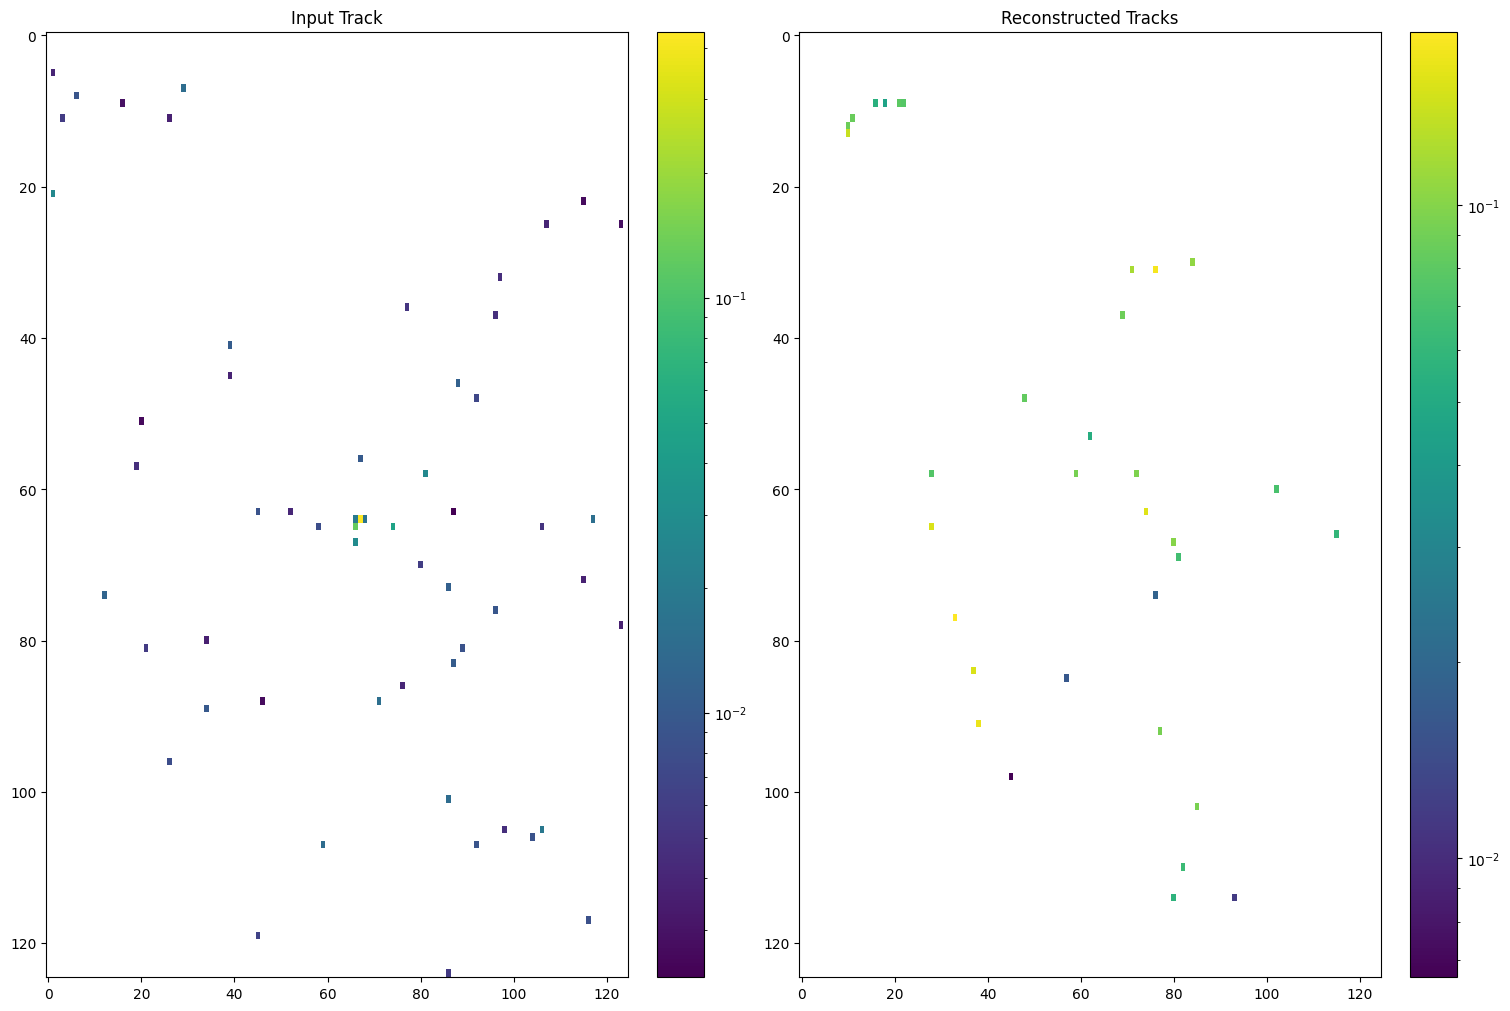

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10), constrained_layout=True)


tracks = axs[0].imshow(input_tracks,aspect='auto', norm=colors.LogNorm())
axs[0].set_title('Input Track')
fig.colorbar(tracks, ax=axs[0])

predicted_tracks = axs[1].imshow(output_tracks,aspect='auto', norm=colors.LogNorm())
axs[1].set_title('Reconstructed Tracks')
fig.colorbar(predicted_tracks, ax=axs[1])


In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphAutoEncoder(input_dim =3 , hidden_dim = 64, output_dim=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(50):
    model.train()
    for train_data in train_ecal_dataloader:
        train_data = train_data.to(device)
        # print(train_data)
        optimizer.zero_grad()
        output= model(train_data)
        # print(output.shape)
        # print(train_data.x.shape)
        loss = criterion(output,train_data.x.float())
        
        loss.backward()
        optimizer.step()
    if (epoch+1)%5 ==0:
        print(f'Epoch: {epoch+1}, Train Loss: {loss:.4f}')

Epoch: 5, Train Loss: 136.6676
Epoch: 10, Train Loss: 155.5792
Epoch: 15, Train Loss: 90.4594
Epoch: 20, Train Loss: 70.9459
Epoch: 25, Train Loss: 64.1926
Epoch: 30, Train Loss: 54.6946
Epoch: 35, Train Loss: 49.7249
Epoch: 40, Train Loss: 46.6185
Epoch: 45, Train Loss: 48.9636
Epoch: 50, Train Loss: 43.9336


In [14]:
test_data_ecal = next(iter(test_ecal_dataloader))[0]
model.eval()
test_pred_ecal = model(test_data_ecal.to(device))
print(test_pred_ecal.shape)

image_size = 125
input_ecal = np.zeros((image_size, image_size))
for x, y, val in test_data_ecal.x.detach().cpu():
    x, y = int(x), int(y)
    if 0 <= x < image_size and 0 <= y < image_size:
        input_ecal[y, x] = val

output_ecal = np.zeros((image_size, image_size))
for x, y, val in test_pred_ecal.detach().cpu():
    x, y = int(x), int(y)
    if 0 <= x < image_size and 0 <= y < image_size:
        output_ecal[y, x] = val



torch.Size([106, 3])


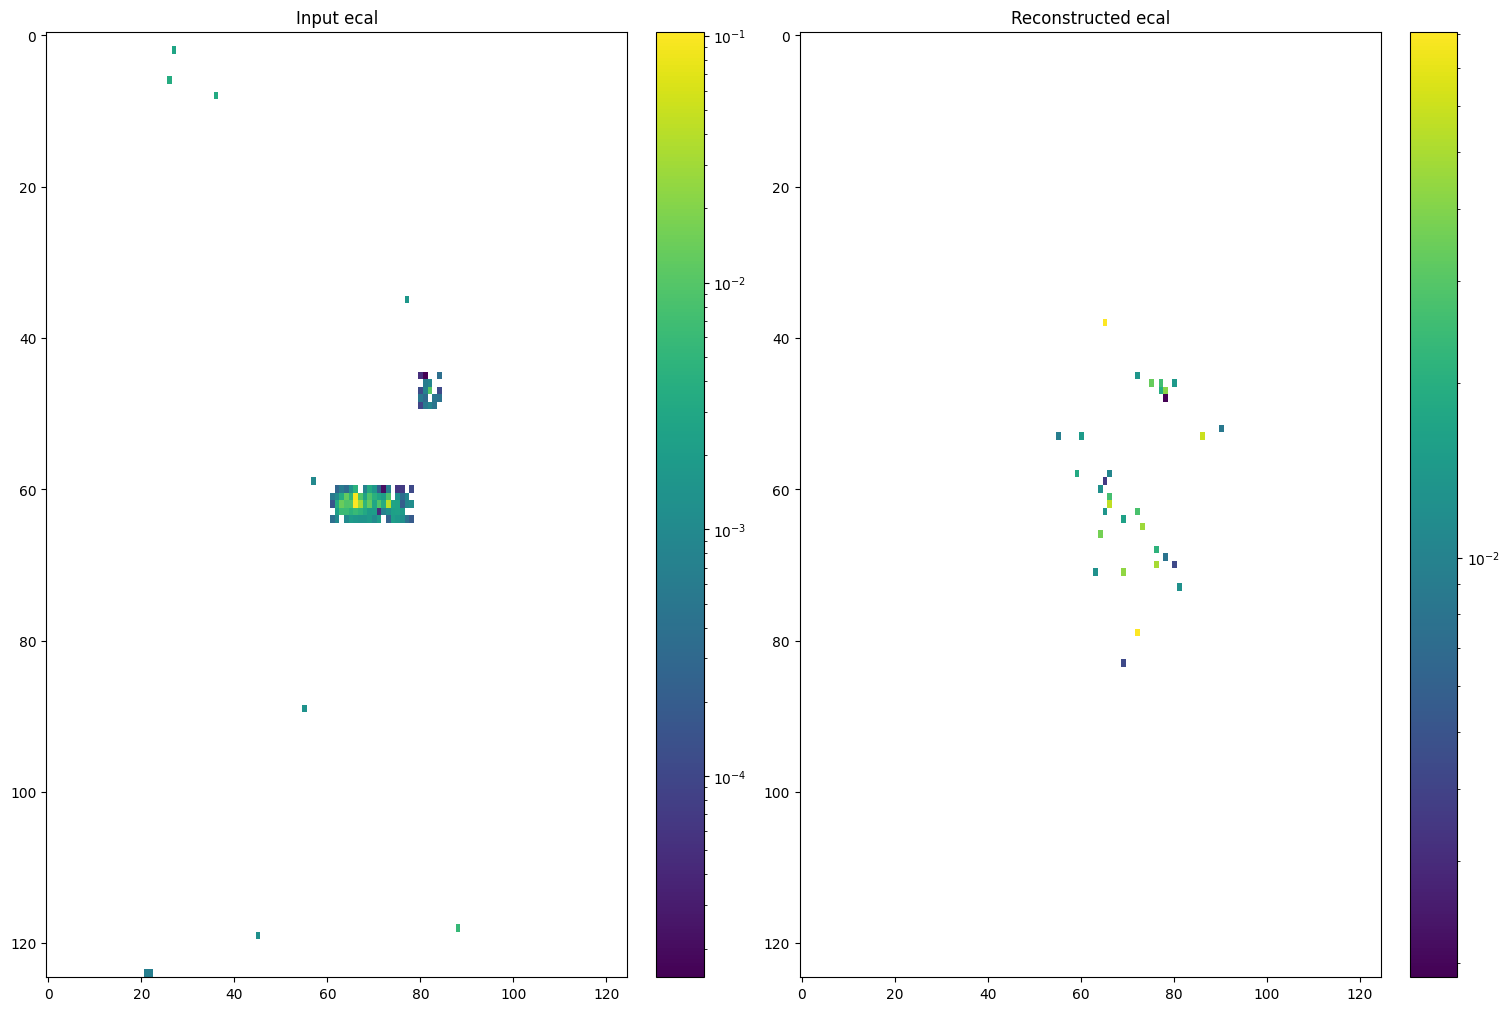

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10), constrained_layout=True)


ecal = axs[0].imshow(input_ecal,aspect='auto', norm=colors.LogNorm())
axs[0].set_title('Input ecal')
fig.colorbar(ecal, ax=axs[0])

predicted_ecal = axs[1].imshow(output_ecal,aspect='auto', norm=colors.LogNorm())
axs[1].set_title('Reconstructed ecal')
fig.colorbar(predicted_ecal, ax=axs[1])


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphAutoEncoder(input_dim =3 , hidden_dim = 64, output_dim=16).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

for epoch in range(50):
    model.train()
    for train_data in train_hcal_dataloader:
        train_data = train_data.to(device)
        # print(train_data)
        optimizer.zero_grad()
        output= model(train_data)
        # print(output.shape)
        # print(train_data.x.shape)
        loss = criterion(output,train_data.x.float())
        
        loss.backward()
        optimizer.step()
    if (epoch+1)%5 ==0:
        print(f'Epoch: {epoch+1}, Train Loss: {loss:.4f}')

Epoch: 5, Train Loss: 32.2296
Epoch: 10, Train Loss: 32.3262
Epoch: 15, Train Loss: 30.1490
Epoch: 20, Train Loss: 30.4424
Epoch: 25, Train Loss: 30.5808
Epoch: 30, Train Loss: 29.3201
Epoch: 35, Train Loss: 25.6990
Epoch: 40, Train Loss: 22.6677
Epoch: 45, Train Loss: 19.7216
Epoch: 50, Train Loss: 19.0967


In [21]:
test_data_hcal = next(iter(test_hcal_dataloader))[0]
model.eval()
test_pred_hcal = model(test_data_hcal.to(device))
print(test_pred_hcal.shape)

image_size = 125
input_hcal = np.zeros((image_size, image_size))
for x, y, val in test_data_hcal.x.detach().cpu():
    x, y = int(x), int(y)
    if 0 <= x < image_size and 0 <= y < image_size:
        input_hcal[y, x] = val

output_hcal = np.zeros((image_size, image_size))
for x, y, val in test_pred_hcal.detach().cpu():
    x, y = int(x), int(y)
    if 0 <= x < image_size and 0 <= y < image_size:
        output_hcal[y, x] = val



torch.Size([400, 3])


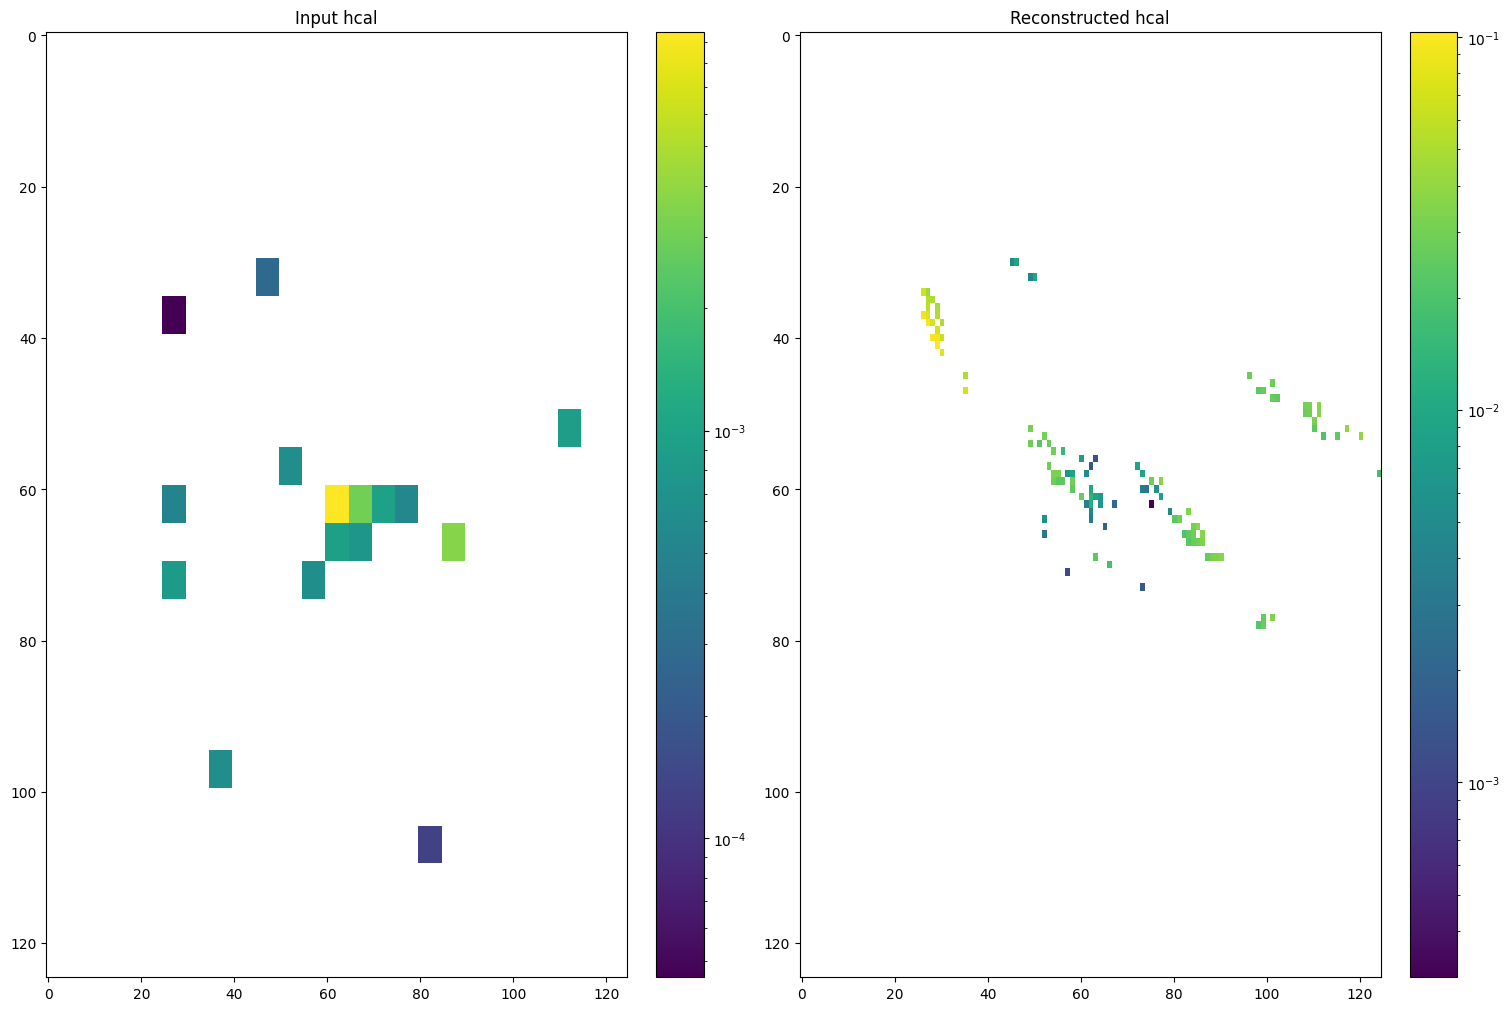

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10), constrained_layout=True)


hcal = axs[0].imshow(input_hcal,aspect='auto', norm=colors.LogNorm())
axs[0].set_title('Input hcal')
fig.colorbar(hcal, ax=axs[0])

predicted_hcal = axs[1].imshow(output_hcal,aspect='auto', norm=colors.LogNorm())
axs[1].set_title('Reconstructed hcal')
fig.colorbar(predicted_hcal, ax=axs[1])


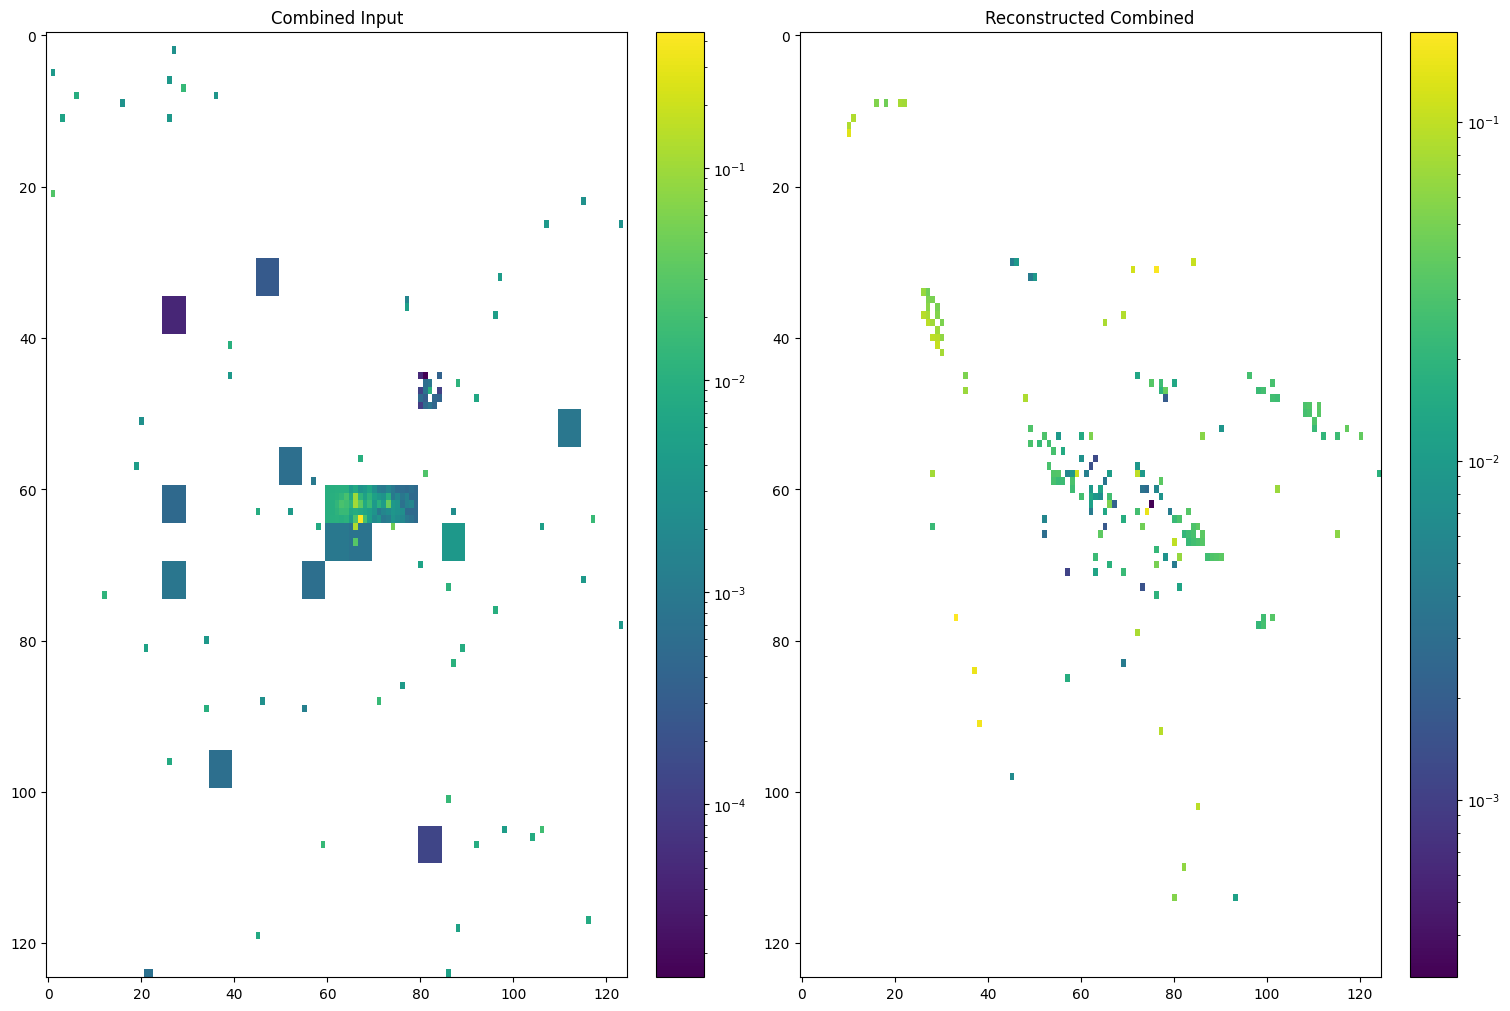

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(15, 10), constrained_layout=True)

combined_input = input_tracks + input_ecal + input_hcal
combined_output = output_tracks + output_ecal + output_hcal

input_combined = axs[0].imshow(combined_input,aspect='auto', norm=colors.LogNorm())
axs[0].set_title('Combined Input')
fig.colorbar(input_combined, ax=axs[0])

predicted_combined = axs[1].imshow(combined_output,aspect='auto', norm=colors.LogNorm())
axs[1].set_title('Reconstructed Combined')
fig.colorbar(predicted_combined, ax=axs[1])

## DISCUSSION

* A simple Graph autoencoder is able to extract the underlying pattern better than VAE for the given raw data.

* GCN operates by aggregating feature information from neighboring nodes in graph to update central nodes representation. It can only take node features as input.

* The results can be further improved by using a more complex architecture and using layers like SageConv,GATcConv and pooling mechanisms

## REFERENCES -
1) https://arxiv.org/pdf/2104.01725.pdf
2) https://ml4physicalsciences.github.io/2020/files/NeurIPS_ML4PS_2020_138.pdf
3) https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html
